# Notebook Telstra Network Disruption

Predecir la gravedad de la falla en 3 niveles

The goal of the problem is to predict Telstra network's fault severity at a time at a particular location based on the log data available. Each row in the main dataset (train.csv, test.csv) represents a location and a time point. They are identified by the "id" column, which is the key "id" used in other data files. 

Fault severity has 3 categories: 0,1,2 (0 meaning no fault, 1 meaning only a few, and 2 meaning many). 

Different types of features are extracted from log files and other sources: event_type.csv, log_feature.csv, resource_type.csv, severity_type.csv. 

Note: “severity_type” is a feature extracted from the log files (in severity_type.csv). Often this is a severity type of a warning message coming from the log. "severity_type" is categorical. It does not have an ordering. “fault_severity” is a measurement of actual reported faults from users of the network and is the target variable (in train.csv).
File descriptions

    train.csv - the training set for fault severity
    test.csv - the test set for fault severity
    sample_submission.csv - a sample submission file in the correct format
    event_type.csv - event type related to the main dataset
    log_feature.csv - features extracted from log files
    resource_type.csv - type of resource related to the main dataset
    severity_type.csv -  severity type of a warning message coming from the log


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

# Descripcion de tablas

## Tabla Event_type

Corresponde a la tabla de tipo de evento que se sucito, relacionado con el  dataset principal

Se analizo por que habia en algunos casos 2 o 3 columnas y corresponde a eventos donde se susitaron dos eventos en el mismo id.

<img src="event_type_exp.png">

Solo corresponde al 8% de los eventos registrados por lo que __no__ se tomaran esos registros.

In [2]:
event_type = pd.read_csv("event_type.csv", error_bad_lines=False, warn_bad_lines=False)
event_type.drop(31170,inplace=True) # se quita por que tiene un error
event_type["id"] = event_type["id"].astype(int)
event_type["event_type"] = event_type.event_type.astype("category")

In [3]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [4]:
event_type.tail()

,id,event_type
31165,3761,event_type 11
31166,8720,event_type 11
31167,6488,event_type 11
31168,878,event_type 11
31169,4464,event_type 11


In [ ]:
event_type.profile_report()

## Se repiten algunos ID's ojo al hacer el merge por que generan duplicados.

### Transformaciones a tipo de evento
Variable categorica nominal, se aplicara one hot encoding (pd.get_dummies)

In [5]:
event_type.event_type.value_counts(normalize=True)

event_type 11    0.253064
event_type 35    0.212223
event_type 34    0.190151
event_type 15    0.141001
event_type 20    0.046776
event_type 54    0.021944
event_type 13    0.018672
event_type 42    0.015335
event_type 44    0.014950
event_type 23    0.013763
event_type 14    0.010587
event_type 43    0.009817
event_type 22    0.007154
event_type 50    0.004941
event_type 10    0.004652
event_type 21    0.004363
event_type 18    0.002342
event_type 47    0.002214
event_type 26    0.002085
event_type 32    0.002021
event_type 30    0.001925
event_type 45    0.001700
event_type 24    0.001476
event_type 27    0.001412
event_type 29    0.001347
event_type 40    0.001283
event_type 46    0.001219
event_type 2     0.001187
event_type 28    0.001027
event_type 8     0.000930
event_type 6     0.000898
event_type 5     0.000834
event_type 7     0.000770
event_type 3     0.000610
event_type 38    0.000610
event_type 36    0.000577
event_type 39    0.000577
event_type 53    0.000545
event_type 4

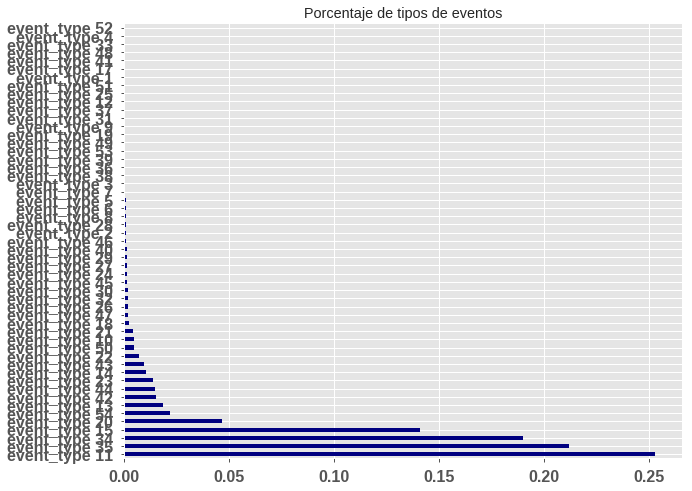

In [6]:
event_type.event_type.value_counts(normalize=True).plot.barh(color='navy', figsize=(10,8), title='Porcentaje de tipos de eventos')

Agruparemos los tipos de evento por que son un monton nos quedaremos con el top 20.

Se podria tomar un decil pero se dejara para despues

In [26]:
popular_events = event_type.event_type.value_counts().index.values[:40]

event_type["event_type_grouped"] = np.where(event_type.event_type.isin(popular_events),event_type.event_type,'others')

In [27]:
event_type.event_type_grouped.value_counts(normalize=True)

event_type 11    0.253064
event_type 35    0.212223
event_type 34    0.190151
event_type 15    0.141001
event_type 20    0.046776
event_type 54    0.021944
event_type 13    0.018672
event_type 42    0.015335
event_type 44    0.014950
event_type 23    0.013763
event_type 14    0.010587
event_type 43    0.009817
event_type 22    0.007154
event_type 50    0.004941
event_type 10    0.004652
event_type 21    0.004363
event_type 18    0.002342
event_type 47    0.002214
event_type 26    0.002085
others           0.002021
event_type 32    0.002021
event_type 30    0.001925
event_type 45    0.001700
event_type 24    0.001476
event_type 27    0.001412
event_type 29    0.001347
event_type 40    0.001283
event_type 46    0.001219
event_type 2     0.001187
event_type 28    0.001027
event_type 8     0.000930
event_type 6     0.000898
event_type 5     0.000834
event_type 7     0.000770
event_type 3     0.000610
event_type 38    0.000610
event_type 39    0.000577
event_type 36    0.000577
event_type 4

In [28]:
event_type.event_type_grouped.value_counts(normalize=True).median()

0.0020211742059672764

Text(0.5,0,'Porcentaje %')

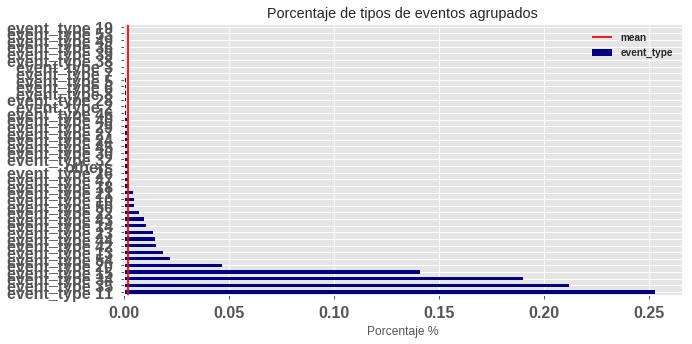

In [29]:
event_type.event_type_grouped.value_counts(normalize=True).plot.barh(color='navy', figsize=(10,5), title='Porcentaje de tipos de eventos agrupados')
plt.vlines(event_type.event_type_grouped.value_counts(normalize=True).median(),plt.ylim()[0],plt.ylim()[1], color='r')
plt.legend(['mean','event_type',])
plt.xlabel('Porcentaje %')

In [30]:
# check de datos # solo se hara el join de la columna event_type_grouped
pd.concat([event_type.head(),event_type.tail()])

,id,event_type,event_type_grouped
0,6597,event_type 11,event_type 11
1,8011,event_type 15,event_type 15
2,2597,event_type 15,event_type 15
3,5022,event_type 15,event_type 15
4,5022,event_type 11,event_type 11
31165,3761,event_type 11,event_type 11
31166,8720,event_type 11,event_type 11
31167,6488,event_type 11,event_type 11
31168,878,event_type 11,event_type 11
31169,4464,event_type 11,event_type 11


## Tabla Train

In [31]:
train = pd.read_csv("train.csv")
train.profile_report()

7300 registros....

Como vimos aqui solo hay id's unicos y para colmo esta desbalanceado el problema... lo describiremos aqui abajo

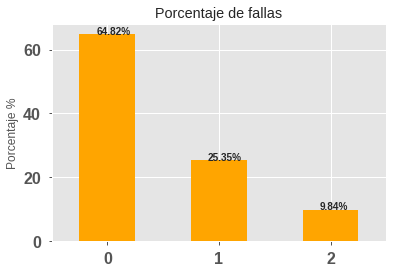

In [32]:
res = train.fault_severity.value_counts(normalize=True) * 100
res.plot.bar(rot=0, color='orange', title='Porcentaje de fallas')
plt.ylabel('Porcentaje %')
for ind,i in enumerate(res.values):
    plt.text(ind-0.1,i,str(round(i,2))+'%')

Recordar que:
+ 0 - leve
+ 1 - grave
+ 2 - Muy grave... casi explota o exploto :v

Una diferencia del 30 y 50 porciento !!! 

Posible aplicar un SMOTE para generar mas registros al entrenar el modelo.


    id:  identificador unico de lugar y tiempo
    location: identificador unico de ubicacion
    fault_severity: variable a predecir


In [33]:
# puede que exista una pequenia probabilidad de que sean ligares contiguos, probabremos agregando la variable numerica de la ubicacion
train["location_numeric"] = train.location.str.split().str[1].astype(int)

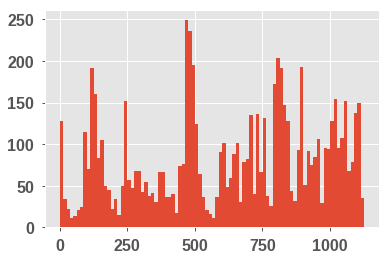

In [34]:
train.location_numeric.hist(bins=90)
# Parece que si hay lugares donde se conglomeran las fallas.

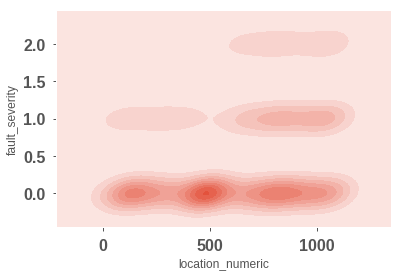

In [35]:
sns.kdeplot(train.location_numeric,train.fault_severity, shade=True)

Se concentran las severidades, dependiendo de la locacion, entonces si es importante ponerla como numerica

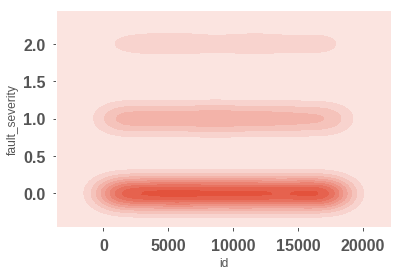

In [36]:
sns.kdeplot(train.id,train.fault_severity, shade=True)

Al parecer no hay relacion entre la severidad de la falla y el id.

In [37]:
pd.concat([train.head(10),train.tail(10)])

,id,location,fault_severity,location_numeric
0,14121,location 118,1,118
1,9320,location 91,0,91
2,14394,location 152,1,152
3,8218,location 931,1,931
4,14804,location 120,0,120
5,1080,location 664,0,664
6,9731,location 640,0,640
7,15505,location 122,0,122
8,3443,location 263,1,263
9,13300,location 613,1,613


## severity_type

In [38]:
severity_type = pd.read_csv("severity_type.csv")
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [39]:
severity_type.profile_report()

Por lo que veo solo hay 5 categorias y pondera la categoria 2 y 1. 

Podria intentar tratarla como variable ordinal o nominal... juuummm

+ nominal one hot encoding (dummies)
+ ordinal pues por el numero que tienen

In [40]:
# ordinal
severity_type["severety_type_ordinal"] = severity_type.severity_type.str.split().str[1].astype(int)

## Tabla log_feature

In [41]:
log_feature = pd.read_csv("log_feature.csv")

In [42]:
log_feature.profile_report()

+ son un buen de log_features, tambien agruparlas en el top 20.
+ en volumne en el histograma vemos que hay outliers, re quitaran esos registros respetando el quantil 0.999

/home/serch/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


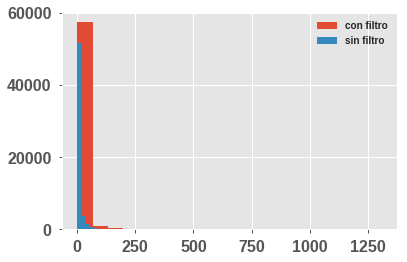

In [43]:
plt.subplot()
log_feature.volume.hist(bins=20)
plt.subplot()
log_feature[log_feature.volume < log_feature.volume.quantile(0.999)].volume.hist(bins=20)
plt.legend(['con filtro','sin filtro'])

In [44]:
log_feature = log_feature[log_feature.volume < log_feature.volume.quantile(0.999)]

In [45]:
log_feature['log_volume'] = 1 + np.log(log_feature.volume)

In [46]:
popular_log_features = log_feature.log_feature.value_counts().index.values[:50]

log_feature["log_features_grouped"] = np.where(log_feature.log_feature.isin(popular_log_features), log_feature.log_feature,'others')

Text(0.5,0,'Porcentaje %')

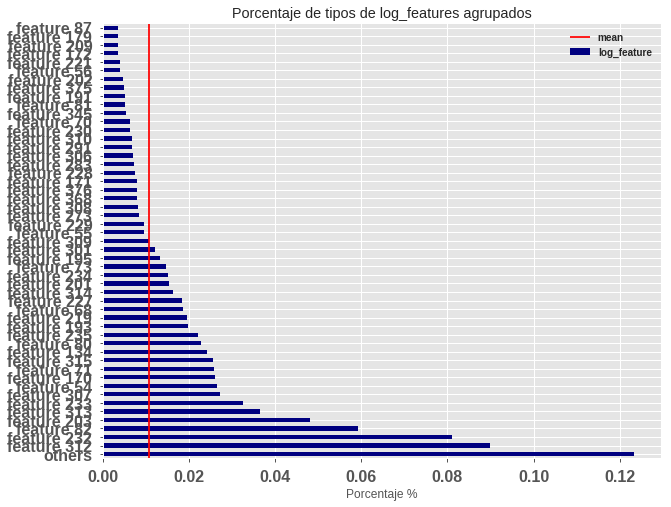

In [47]:
log_feature.log_features_grouped.value_counts(normalize=True).plot.barh(color='navy', figsize=(10,8), title='Porcentaje de tipos de log_features agrupados')
plt.vlines(log_feature.log_features_grouped.value_counts(normalize=True).median(),plt.ylim()[0],plt.ylim()[1], color='r')
plt.legend(['mean','log_feature',])
plt.xlabel('Porcentaje %')

se ve horrible pero llega hasta 300 si se reduce el valor maximo.

Podemos obtener estadisticos sobre el volumen como el valor promedio con respecto al que tiene.

Asi como otras metricas. Como la diferencia del volumen con respecto al promedio de su feature.

In [48]:
# se quita el minimo por que no cambia con respecto a los demas
log_feature_stats = log_feature.groupby('log_features_grouped').volume.describe().drop('min',1)

In [49]:
log_feature_stats

,count,mean,std,25%,50%,75%,max
log_features_grouped,,,,,,,
feature 134,1419.0,1.328400,1.441126,1.00,1.0,1.00,23.0
feature 170,1526.0,7.665138,17.059854,1.00,2.0,6.00,161.0
feature 171,459.0,4.692810,6.340017,1.00,2.0,6.00,70.0
feature 172,213.0,19.234742,51.654159,1.00,2.0,4.00,294.0
feature 179,207.0,3.830918,8.311614,1.00,2.0,3.00,90.0
feature 191,301.0,4.279070,5.217457,1.00,2.0,5.00,44.0
feature 193,1160.0,4.803448,8.545528,1.00,2.0,5.00,145.0
feature 195,783.0,8.553001,16.496592,2.00,3.0,8.00,180.0
feature 201,902.0,4.388027,12.746055,1.00,2.0,4.00,299.0


Caracteristicas del feature

## Tabla test
Lo mismo que train pero simplemente que no tiene la variable a predecir

In [50]:
test = pd.read_csv("test.csv")

In [51]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [52]:
# puede que exista una pequenia probabilidad de que sean ligares contiguos, probabremos agregando la variable numerica de la ubicacion
test["location_numeric"] = test.location.str.split().str[1].astype(int)

## Tabla resource_type

Esta tabla tiene columnas de mas en algunos registros que corresponde solo al 7% por lo que se eliminaran esos registros

In [53]:
resource_type = pd.read_csv("resource_type.csv", error_bad_lines=False, warn_bad_lines=False)
resource_type.drop(21076,inplace=True) # se quita por que tiene un error
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [54]:
resource_type.profile_report()

Hay solo 10 tipos de recursos. Por lo que pueden utilizarse variables nominales, Se trataran como one hot encoding

## Tabla sample_submission
Simplemente es como tiene que venir la tabla de prediccion del test data

In [55]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


# Preprocesamiento de datos y analisis subsecuente
Ahora si va el despapaye de datos a generar los joins y no tener duplicados OJO!!!! 

Por que aaaaa como son esos joins

    train.csv - the training set for fault severity
    event_type.csv - event type related to the main dataset LISTA
    log_feature.csv - features extracted from log files
    resource_type.csv - type of resource related to the main dataset
    severity_type.csv -  severity type of a warning message coming from the log
    
Ahi estan las tablas y las cruzaras todas por id

para las dummies tienes que agruparlas por id si no se friega por los duplicados

In [56]:
# se hara una funcion por que se repetira 3 veces
def get_dumi_dumi(df, col, idx):
    df_temp = pd.get_dummies(df, columns=[col]).groupby(idx).max()
    return df_temp

In [57]:
def check_inicio_final(df,n=5):
    return pd.concat([df.head(n),df.tail(n)])

In [58]:

# COn max por que queremos solo la dummies
## PRUEBA ###
# temp = pd.get_dummies(b, columns=['event_type_grouped']).groupby(['id'], as_index = False).max()
# temp.set_index('id',inplace=True)
# temp

# te devuelve los id sorteados

# event_type_dummies = pd.get_dummies(event_type, columns=['event_type_grouped']).groupby(['id'], as_index = False).max()
# event_type_dummies.set_index('id',inplace=True)
# event_type_dummies.head()

## PRUEBA ###


+ dummies de tipos de evento

In [59]:
%%time
event_type_dummies = get_dumi_dumi(event_type,'event_type_grouped','id')

CPU times: user 1min 1s, sys: 340 ms, total: 1min 2s
Wall time: 1min 1s


In [60]:
check_inicio_final(event_type_dummies)

,event_type_grouped_event_type 10,event_type_grouped_event_type 11,event_type_grouped_event_type 13,event_type_grouped_event_type 14,event_type_grouped_event_type 15,event_type_grouped_event_type 18,event_type_grouped_event_type 19,event_type_grouped_event_type 2,event_type_grouped_event_type 20,event_type_grouped_event_type 21,...,event_type_grouped_event_type 47,event_type_grouped_event_type 49,event_type_grouped_event_type 5,event_type_grouped_event_type 50,event_type_grouped_event_type 53,event_type_grouped_event_type 54,event_type_grouped_event_type 6,event_type_grouped_event_type 7,event_type_grouped_event_type 8,event_type_grouped_others
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18549,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18550,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18551,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


+ numero de eventos en el mismo id

In [61]:
event_type_count = event_type.groupby('id').event_type.count().reset_index()
event_type_count.columns = ['id','number_of_event_types']
event_type_count.head()

,id,number_of_event_types
0,1,2
1,2,2
2,3,1
3,4,1
4,5,2


ya quedaron para hacer el merge. OJO al ponerle el nombre de las columnas 

+ dummie tipos de recursos

In [62]:
resource_type_dummies = get_dumi_dumi(resource_type,'resource_type','id')

In [63]:
check_inicio_final(resource_type_dummies)

,resource_type_resource_type 1,resource_type_resource_type 10,resource_type_resource_type 2,resource_type_resource_type 3,resource_type_resource_type 4,resource_type_resource_type 5,resource_type_resource_type 6,resource_type_resource_type 7,resource_type_resource_type 8,resource_type_resource_type 9
id,,,,,,,,,,
1,0,0,0,0,0,0,1,0,1,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0
18548,0,0,1,0,0,0,0,0,0,0
18549,0,0,1,0,0,0,0,0,0,0
18550,0,0,0,0,0,0,0,0,1,0
18551,0,0,0,0,0,0,0,0,1,0


+ numero de recursos

In [64]:
resource_type_count = resource_type.groupby('id').resource_type.count().reset_index()
resource_type_count.columns = ['id','number_of_resource_type']
resource_type_count.head()

,id,number_of_resource_type
0,1,2
1,2,1
2,3,1
3,4,1
4,5,1


+ Gravedad de la falla en logs categorica Ordinal

In [65]:
# solo copiaremos esta
severity_type.severety_type_ordinal.head()

0    2
1    2
2    2
3    1
4    1
Name: severety_type_ordinal, dtype: int64

+ dummie log_features_agrupado

In [66]:
log_feature_dummi = get_dumi_dumi(log_feature,'log_features_grouped','id').drop([
    'volume','log_volume','log_feature'], 1)

In [67]:
check_inicio_final(log_feature_dummi)

,log_features_grouped_feature 134,log_features_grouped_feature 170,log_features_grouped_feature 171,log_features_grouped_feature 172,log_features_grouped_feature 179,log_features_grouped_feature 191,log_features_grouped_feature 193,log_features_grouped_feature 195,log_features_grouped_feature 201,log_features_grouped_feature 202,...,log_features_grouped_feature 56,log_features_grouped_feature 68,log_features_grouped_feature 70,log_features_grouped_feature 71,log_features_grouped_feature 73,log_features_grouped_feature 80,log_features_grouped_feature 81,log_features_grouped_feature 82,log_features_grouped_feature 87,log_features_grouped_others
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18549,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18551,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


+ Conteo de log_features

In [68]:
log_feature_type_count = log_feature.groupby('id').log_feature.count().reset_index()
log_feature_type_count.columns = ['id','number_of_log_feature']
log_feature_type_count.head()

,id,number_of_log_feature
0,1,3
1,2,5
2,3,1
3,4,1
4,5,2


+  Estadisticos de volumen

In [69]:
feature_vol_stats = log_feature.groupby('id').volume.describe()

In [70]:
feature_vol_stats.columns = ['log_feature_vol_count', 'log_feature_vol_mean', 
                                 'log_feature_vol_std', 'log_feature_vol_min', 'log_feature_vol_25%', 
                                 'log_feature_vol_50%', 'log_feature_vol_75%', 'log_feature_vol_max']

In [71]:
check_inicio_final(feature_vol_stats)

,log_feature_vol_count,log_feature_vol_mean,log_feature_vol_std,log_feature_vol_min,log_feature_vol_25%,log_feature_vol_50%,log_feature_vol_75%,log_feature_vol_max
id,,,,,,,,
1,3.0,1.666667,0.577350,1.0,1.50,2.0,2.00,2.0
2,5.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
3,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
4,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
5,2.0,8.500000,3.535534,6.0,7.25,8.5,9.75,11.0
18548,6.0,3.666667,0.516398,3.0,3.25,4.0,4.00,4.0
18549,6.0,1.333333,0.516398,1.0,1.00,1.0,1.75,2.0
18550,2.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
18551,2.0,3.500000,3.535534,1.0,2.25,3.5,4.75,6.0


+ Estadisticos de $Ln(1+volumne)$

In [72]:
feature_log_vol_stats = log_feature.groupby('id').log_volume.describe()

In [73]:
feature_log_vol_stats.columns = ['log_feature_logvol_count', 'log_feature_logvol_mean', 
                                 'log_feature_logvol_std', 'log_feature_logvol_min', 'log_feature_logvol_25%', 
                                 'log_feature_logvol_50%', 'log_feature_logvol_75%', 'log_feature_logvol_max']

In [74]:
check_inicio_final(feature_log_vol_stats)

,log_feature_logvol_count,log_feature_logvol_mean,log_feature_logvol_std,log_feature_logvol_min,log_feature_logvol_25%,log_feature_logvol_50%,log_feature_logvol_75%,log_feature_logvol_max
id,,,,,,,,
1,3.0,1.462098,0.400189,1.000000,1.346574,1.693147,1.693147,1.693147
2,5.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.0,1.693147,NaN,1.693147,1.693147,1.693147,1.693147,1.693147
4,1.0,2.098612,NaN,2.098612,2.098612,2.098612,2.098612,2.098612
5,2.0,3.094827,0.428603,2.791759,2.943293,3.094827,3.246361,3.397895
18548,6.0,2.290400,0.148558,2.098612,2.170533,2.386294,2.386294,2.386294
18549,6.0,1.231049,0.357940,1.000000,1.000000,1.000000,1.519860,1.693147
18550,2.0,2.098612,0.000000,2.098612,2.098612,2.098612,2.098612,2.098612
18551,2.0,1.895880,1.266965,1.000000,1.447940,1.895880,2.343820,2.791759


# Hora de unir las tablas y analizar si hay patrones entre las nuevas variables

Merge dummies event type y train = df

In [75]:
df = None #por si la riegas regresas aqui

In [76]:
df = train.merge(event_type_dummies, on='id', how='left')

In [77]:
print(len(train))
len(df)

7381


7381

In [78]:
df.head(2)

,id,location,fault_severity,location_numeric,event_type_grouped_event_type 10,event_type_grouped_event_type 11,event_type_grouped_event_type 13,event_type_grouped_event_type 14,event_type_grouped_event_type 15,event_type_grouped_event_type 18,...,event_type_grouped_event_type 47,event_type_grouped_event_type 49,event_type_grouped_event_type 5,event_type_grouped_event_type 50,event_type_grouped_event_type 53,event_type_grouped_event_type 54,event_type_grouped_event_type 6,event_type_grouped_event_type 7,event_type_grouped_event_type 8,event_type_grouped_others
0,14121,location 118,1,118,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,91,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merge numero de event type y df = df

In [79]:
df = df.merge(event_type_count, on='id', how='left')

In [80]:
print(len(train))
len(df)

7381


7381

Merge resource_type_dummies con df = df

In [81]:
df = df.merge(resource_type_dummies, on='id', how='left')

In [82]:
print(len(train))
len(df)

7381


7381

Merge resource_type_count con df = df

In [83]:
df = df.merge(resource_type_count, on='id', how='left')

In [84]:
print(len(train))
len(df)

7381


7381

Merge severery type ordinal con df = df

In [85]:
severity_type.head()

,id,severity_type,severety_type_ordinal
0,6597,severity_type 2,2
1,8011,severity_type 2,2
2,2597,severity_type 2,2
3,5022,severity_type 1,1
4,6852,severity_type 1,1


In [86]:
df = df.merge(severity_type[['id', 'severety_type_ordinal']], on='id', how='left')

In [87]:
print(len(train))
len(df)

7381


7381

Merge log_feature_dummies con df = df

In [88]:
df = df.merge(log_feature_dummi, on='id', how='left')

In [89]:
print(len(train))
len(df)

7381


7381

Merge log_feature_type_count con df = df

In [90]:
df = df.merge(log_feature_type_count, on='id', how='left')

In [91]:
df = df.merge(feature_log_vol_stats, on='id', how='left')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7381 entries, 0 to 7380
Columns: 118 entries, id to log_feature_logvol_max
dtypes: float64(60), int64(6), object(1), uint8(51)
memory usage: 4.2+ MB


In [93]:
# numero de variables 
len(df.columns) - 2 

116

check si pegaron bien, parace que si

In [94]:
feature_log_vol_stats.loc[409]

log_feature_logvol_count    2.000000
log_feature_logvol_mean     1.895880
log_feature_logvol_std      0.286707
log_feature_logvol_min      1.693147
log_feature_logvol_25%      1.794513
log_feature_logvol_50%      1.895880
log_feature_logvol_75%      1.997246
log_feature_logvol_max      2.098612
Name: 409, dtype: float64

In [95]:
df[df.id == 409]

,id,location,fault_severity,location_numeric,event_type_grouped_event_type 10,event_type_grouped_event_type 11,event_type_grouped_event_type 13,event_type_grouped_event_type 14,event_type_grouped_event_type 15,event_type_grouped_event_type 18,...,log_features_grouped_others,number_of_log_feature,log_feature_logvol_count,log_feature_logvol_mean,log_feature_logvol_std,log_feature_logvol_min,log_feature_logvol_25%,log_feature_logvol_50%,log_feature_logvol_75%,log_feature_logvol_max
5550,409,location 808,0,808,0,1,0,0,1,0,...,0.0,2.0,2.0,1.89588,0.286707,1.693147,1.794513,1.89588,1.997246,2.098612


check de nulos

In [96]:
(1 - len(df.dropna()) / len(df))*100

13.399268391816832

El 13% de las columnas tiene nulos. se checara cuales registros se quitan y cuales se dejan y se rellenan

In [97]:
nul = df.isnull().sum()
nul[nul !=0 ]

log_features_grouped_feature 134      1
log_features_grouped_feature 170      1
log_features_grouped_feature 171      1
log_features_grouped_feature 172      1
log_features_grouped_feature 179      1
log_features_grouped_feature 191      1
log_features_grouped_feature 193      1
log_features_grouped_feature 195      1
log_features_grouped_feature 201      1
log_features_grouped_feature 202      1
log_features_grouped_feature 203      1
log_features_grouped_feature 209      1
log_features_grouped_feature 219      1
log_features_grouped_feature 221      1
log_features_grouped_feature 227      1
log_features_grouped_feature 228      1
log_features_grouped_feature 229      1
log_features_grouped_feature 230      1
log_features_grouped_feature 232      1
log_features_grouped_feature 233      1
log_features_grouped_feature 234      1
log_features_grouped_feature 235      1
log_features_grouped_feature 273      1
log_features_grouped_feature 283      1
log_features_grouped_feature 291      1


In [98]:
# esta fila no tiene info relevante en log features, la quitare.
df[df.log_feature_logvol_min.isnull()]

,id,location,fault_severity,location_numeric,event_type_grouped_event_type 10,event_type_grouped_event_type 11,event_type_grouped_event_type 13,event_type_grouped_event_type 14,event_type_grouped_event_type 15,event_type_grouped_event_type 18,...,log_features_grouped_others,number_of_log_feature,log_feature_logvol_count,log_feature_logvol_mean,log_feature_logvol_std,log_feature_logvol_min,log_feature_logvol_25%,log_feature_logvol_50%,log_feature_logvol_75%,log_feature_logvol_max
2379,17078,location 12,0,12,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
df.drop(df[df.log_feature_logvol_min.isnull()].index, inplace=True)

In [100]:
nul = df.isnull().sum()
nul[nul !=0 ]

log_feature_logvol_std    988
dtype: int64

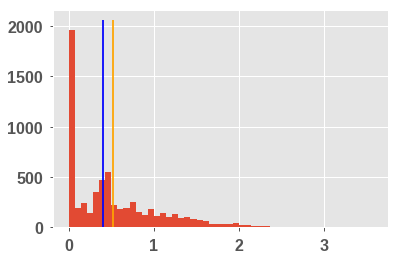

In [101]:
df.log_feature_logvol_std.hist(bins=50)
mi, ma = plt.ylim()
plt.vlines(df.log_feature_logvol_std.mean(), mi, ma, color='orange')
plt.vlines(df.log_feature_logvol_std.median(), mi, ma, color='blue')

In [102]:
df.log_feature_logvol_std.value_counts(normalize=True).head()

0.000000    0.286765
0.490129    0.055538
0.400189    0.035670
0.286707    0.015957
0.346574    0.012046
Name: log_feature_logvol_std, dtype: float64

### Se rellenara con 0's dado que son el 28 % de los datos y solo nos indicaria que no hay un cambio en el volumen en diversos eventos

In [103]:
df.fillna(0,inplace=True)

In [104]:
df[df.isnull().any(axis=1)]

,id,location,fault_severity,location_numeric,event_type_grouped_event_type 10,event_type_grouped_event_type 11,event_type_grouped_event_type 13,event_type_grouped_event_type 14,event_type_grouped_event_type 15,event_type_grouped_event_type 18,...,log_features_grouped_others,number_of_log_feature,log_feature_logvol_count,log_feature_logvol_mean,log_feature_logvol_std,log_feature_logvol_min,log_feature_logvol_25%,log_feature_logvol_50%,log_feature_logvol_75%,log_feature_logvol_max


## Analisis de variables nuevas

In [105]:
df[['id', 'location', 'fault_severity', 'location_numeric',
        'severety_type_ordinal','number_of_event_types',
        'number_of_log_feature', 'log_feature_logvol_count',
       'log_feature_logvol_mean', 'log_feature_logvol_std',
       'log_feature_logvol_min', 'log_feature_logvol_25%',
       'log_feature_logvol_50%', 'log_feature_logvol_75%',
       'log_feature_logvol_max']].profile_report()

/home/serch/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [106]:
cols = ['id', 'location_numeric',
        'severety_type_ordinal','number_of_event_types',
        'number_of_log_feature', 'log_feature_logvol_count',
       'log_feature_logvol_mean', 'log_feature_logvol_std',
       'log_feature_logvol_min', 'log_feature_logvol_25%',
       'log_feature_logvol_50%', 'log_feature_logvol_75%',
       'log_feature_logvol_max']

/home/serch/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


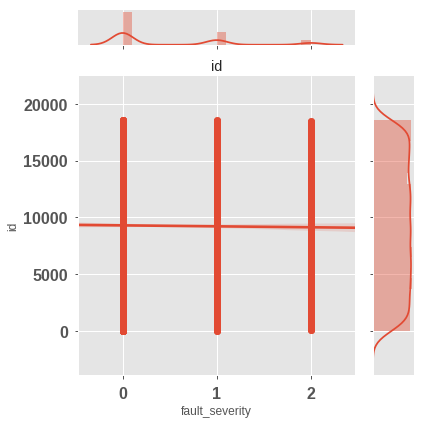

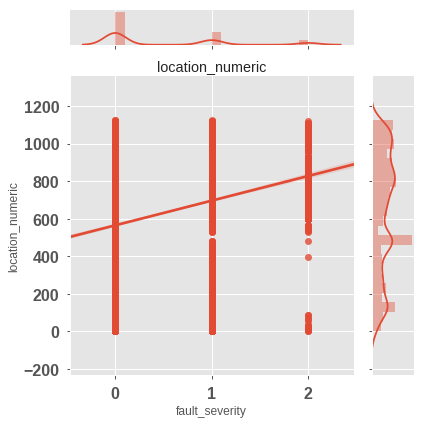

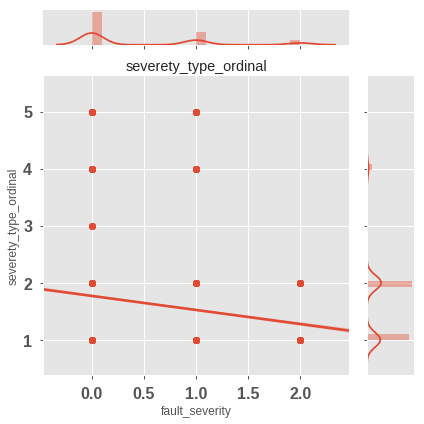

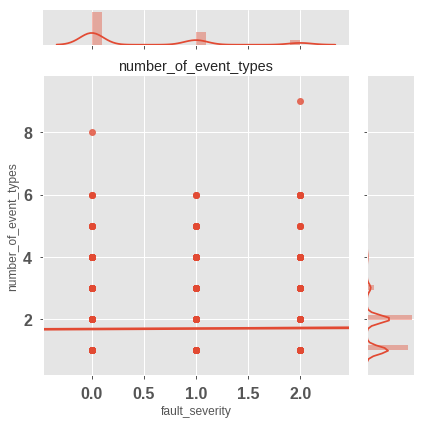

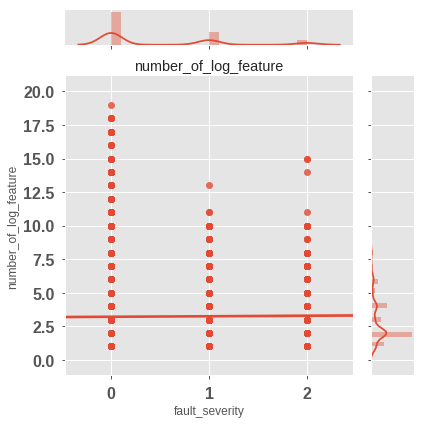

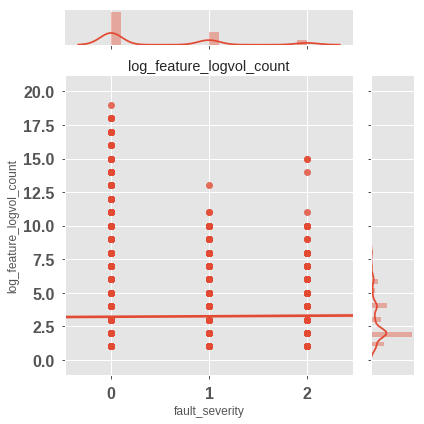

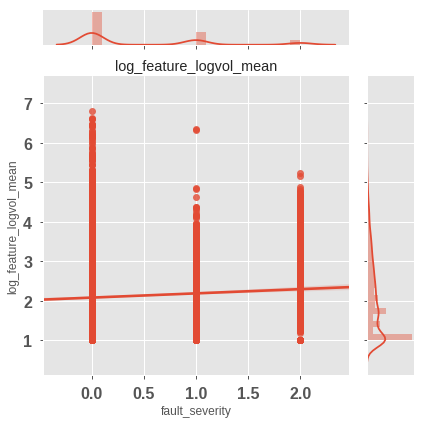

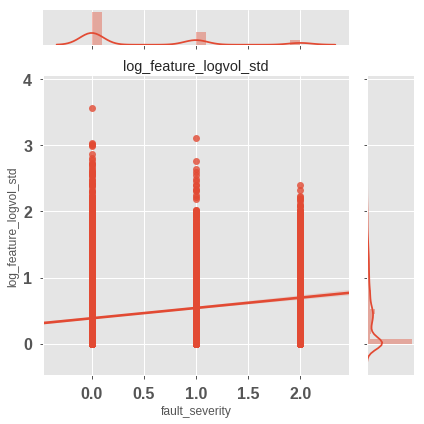

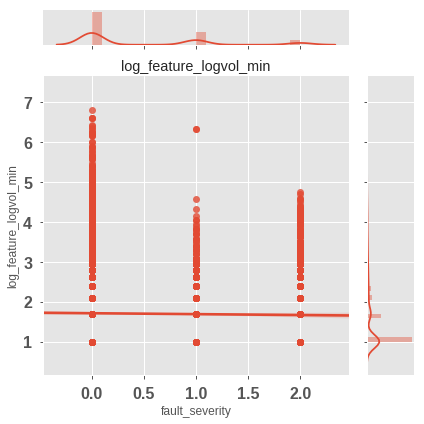

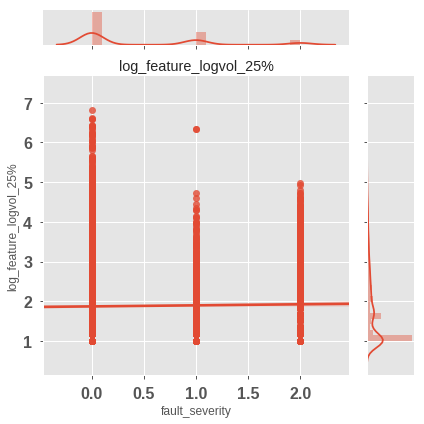

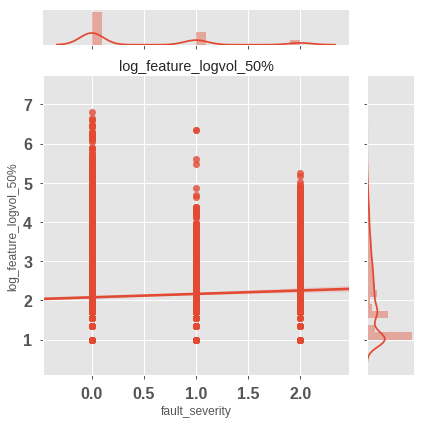

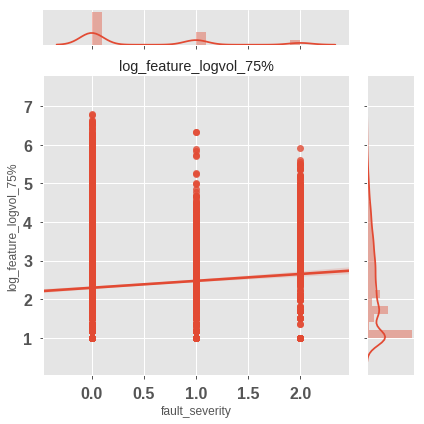

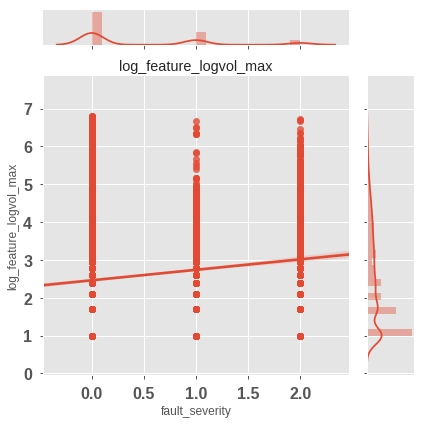

In [107]:
for col in cols:
    sns.jointplot('fault_severity', col,df, kind='reg')
    plt.title(col)
    
    plt.tight_layout()

In [117]:
check_inicio_final(df[['id','location','location_numeric','fault_severity', 'severety_type_ordinal']][df.location_numeric == 1])

,id,location,location_numeric,fault_severity,severety_type_ordinal
144,8011,location 1,1,0,2
245,2588,location 1,1,0,1
395,14595,location 1,1,1,2
464,4848,location 1,1,0,1
845,5259,location 1,1,0,1
5970,16949,location 1,1,0,2
6017,16097,location 1,1,0,1
6553,6914,location 1,1,0,1
6635,2250,location 1,1,0,1
7333,1849,location 1,1,0,2


In [120]:
check_inicio_final(df[['id','location','location_numeric','fault_severity', 'severety_type_ordinal']].sort_values('location_numeric'),20)

,id,location,location_numeric,fault_severity,severety_type_ordinal
3616,2906,location 1,1,0,2
4239,1247,location 1,1,0,1
1148,15952,location 1,1,1,1
7333,1849,location 1,1,0,2
928,5337,location 1,1,0,1
919,3952,location 1,1,1,1
395,14595,location 1,1,1,2
5109,8148,location 1,1,1,1
6635,2250,location 1,1,0,1
4079,5280,location 1,1,1,1


In [109]:
df.columns

Index(['id', 'location', 'fault_severity', 'location_numeric',
       'event_type_grouped_event_type 10', 'event_type_grouped_event_type 11',
       'event_type_grouped_event_type 13', 'event_type_grouped_event_type 14',
       'event_type_grouped_event_type 15', 'event_type_grouped_event_type 18',
       ...
       'log_features_grouped_others', 'number_of_log_feature',
       'log_feature_logvol_count', 'log_feature_logvol_mean',
       'log_feature_logvol_std', 'log_feature_logvol_min',
       'log_feature_logvol_25%', 'log_feature_logvol_50%',
       'log_feature_logvol_75%', 'log_feature_logvol_max'],
      dtype='object', length=118)

## Hora del entrenamiento 

In [ ]:
# preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

#tuneo de metaparametros
from sklearn.model_selection import GridSearchCV

# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [ ]:
x_cols = ['location_numeric',
       'event_type_grouped_event_type_10', 'event_type_grouped_event_type_11',
       'event_type_grouped_event_type_13', 'event_type_grouped_event_type_14',
       'event_type_grouped_event_type_15', 'event_type_grouped_event_type_18',
       'event_type_grouped_event_type_20', 'event_type_grouped_event_type_21',
       'event_type_grouped_event_type_22', 'event_type_grouped_event_type_23',
       'event_type_grouped_event_type_26', 'event_type_grouped_event_type_32',
       'event_type_grouped_event_type_34', 'event_type_grouped_event_type_35',
       'event_type_grouped_event_type_42', 'event_type_grouped_event_type_43',
       'event_type_grouped_event_type_44', 'event_type_grouped_event_type_47',
       'event_type_grouped_event_type_50', 'event_type_grouped_event_type_54',
       'event_type_grouped_others', 'number_of_event_types',
       'resource_type_resource_type_1', 'resource_type_resource_type_10',
       'resource_type_resource_type_2', 'resource_type_resource_type_3',
       'resource_type_resource_type_4', 'resource_type_resource_type_5',
       'resource_type_resource_type_6', 'resource_type_resource_type_7',
       'resource_type_resource_type_8', 'resource_type_resource_type_9',
       'number_of_resource_type', 'severety_type_ordinal',
       'log_features_grouped_feature_134', 'log_features_grouped_feature_170',
       'log_features_grouped_feature_193', 'log_features_grouped_feature_195',
       'log_features_grouped_feature_201', 'log_features_grouped_feature_203',
       'log_features_grouped_feature_219', 'log_features_grouped_feature_227',
       'log_features_grouped_feature_232', 'log_features_grouped_feature_233',
       'log_features_grouped_feature_234', 'log_features_grouped_feature_235',
       'log_features_grouped_feature_301', 'log_features_grouped_feature_307',
       'log_features_grouped_feature_309', 'log_features_grouped_feature_312',
       'log_features_grouped_feature_313', 'log_features_grouped_feature_314',
       'log_features_grouped_feature_315', 'log_features_grouped_feature_54',
       'log_features_grouped_feature_68', 'log_features_grouped_feature_71',
       'log_features_grouped_feature_73', 'log_features_grouped_feature_80',
       'log_features_grouped_feature_82', 'log_features_grouped_others',
       'number_of_log_feature', 'log_feature_logvol_count',
       'log_feature_logvol_mean', 'log_feature_logvol_std',
       'log_feature_logvol_min', 'log_feature_logvol_25%',
       'log_feature_logvol_50%', 'log_feature_logvol_75%',
       'log_feature_logvol_max']

In [ ]:
x_train_test, x_valid, y_train_test, y_valid = train_test_split(
    df[x_cols],
    df.fault_severity,
    test_size=0.1,
    random_state=8)

x_train, x_test, y_train, y_test = train_test_split(x_train_test, 
                                                    y_train_test,
                                                    test_size = 0.2,
                                                    random_state=8)

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE('not majority')
x_sm, y_sm = smote.fit_sample(x_train,y_train)
x_sm = pd.DataFrame(x_sm, columns=x_cols)

In [ ]:
pd.Series(y_sm).value_counts()

## Entrenamiento Light GBM

In [ ]:
d_train = lgb.Dataset(x_sm, y_sm)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['num_class'] = 3
params['metric'] = 'multi_logloss'
params['sub_feature'] = 0.2
params['num_leaves'] = 50
params['min_data'] = 40
params['max_depth'] = 100
params['num_iterations'] = 6000

clf = lgb.train(params, d_train, 100,valid_sets=[d_test], early_stopping_rounds=100,verbose_eval=10000)

# Evaluacion modelo en valid!

In [ ]:
y_pred=clf.predict(x_valid)
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

    Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [ ]:
skplt.metrics.plot_confusion_matrix(y_valid,predictions,cmap='BrBG',normalize=False)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_valid,predictions,cmap='BrBG',normalize=True)

In [ ]:
clf.best_score

## Interpretacion SE HACE EN VALID

In [ ]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [ ]:
f_imp = []
for i in zip(x_valid.columns,clf.feature_importance()):
    f_imp.append(i)
    
importancia = pd.DataFrame(f_imp,columns=['col','value_imp']).sort_values(by='value_imp',ascending=False)
importancia = importancia.head(10)

In [ ]:
pd.DataFrame(f_imp,columns=['col','value_imp']).sort_values(by='value_imp',ascending=False)

### SHAP

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_valid)

In [ ]:
shap.initjs()

In [ ]:
shap.summary_plot(shap_values, x_valid)

In [ ]:
dic_res = {0:'LIGHT',1:'MEDIUM',2:'HIGH'}

for col in x_valid.columns:
    for j in range(3):
        shap.dependence_plot(col, shap_values[j], x_valid, title=dic_res[j])

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], x_valid)

### Predict

hay que generar lo mismo para el test

# Hora de unir las tablas y analizar si hay patrones entre las nuevas variables

Merge dummies event type y train = df

In [ ]:
df_pred = None #por si la riegas regresas aqui

In [ ]:
df_pred = test.merge(event_type_dummies, on='id', how='left')

In [ ]:
print(len(test))
len(df_pred)

In [ ]:
df_pred.head(2)

Merge numero de event type y df = df

In [ ]:
df_pred = df_pred.merge(event_type_count, on='id', how='left')

Merge resource_type_dummies con df = df

In [ ]:
df_pred = df_pred.merge(resource_type_dummies, on='id', how='left')

Merge resource_type_count con df = df

In [ ]:
df_pred = df_pred.merge(resource_type_count, on='id', how='left')

Merge severery type ordinal con df = df

In [ ]:
severity_type.head()

In [ ]:
df_pred = df_pred.merge(severity_type[['id', 'severety_type_ordinal']], on='id', how='left')

Merge log_feature_dummies con df = df

In [ ]:
df_pred = df_pred.merge(log_feature_dummi, on='id', how='left')

Merge log_feature_type_count con df = df

In [ ]:
df_pred = df_pred.merge(log_feature_type_count, on='id', how='left')

In [ ]:
df_pred = df_pred.merge(feature_log_vol_stats, on='id', how='left')

In [ ]:
# numero de variables 
len(df_pred.columns) - 2 

check si pegaron bien, parace que si

In [ ]:
feature_log_vol_stats.loc[3747]

In [ ]:
df_pred[df_pred.id == 3747]

check de nulos

In [ ]:
(1 - len(df_pred.dropna()) / len(df_pred))*100

El 13% de las columnas tiene nulos. se checara cuales registros se quitan y cuales se dejan y se rellenan

In [ ]:
nul = df_pred.isnull().sum()
nul[nul !=0 ]

In [ ]:
# esta fila no tiene info relevante en log features, la quitare.
df_pred[df_pred.log_feature_logvol_min.isnull()]

In [ ]:
# df_pred.drop(df_pred[df_pred.log_feature_logvol_min.isnull()].index, inplace=True)

In [ ]:
df_pred['log_feature_logvol_std'].fillna(0,inplace=True)

In [ ]:
df_pred.fillna(df_pred.median(),inplace=True)

In [ ]:
df_pred.columns = df_pred.columns.str.replace(" ","_")

In [ ]:
x_cols

In [ ]:
clf.predict(df_pred[x_cols])

In [ ]:
predictions = []

for x in clf.predict(df_pred[x_cols]):
    predictions.append(np.argmax(x))

In [ ]:
submission = pd.concat([df_pred.id.astype(str), pd.get_dummies(predictions)],1)

In [ ]:
submission.tail()

In [ ]:
submission.columns = ['id','predict_0','predict_1','predict_2']

In [ ]:
submission.to_csv('prueba_2_light_gbm.csv', index=False)